In [102]:
from tqdm import tqdm

In [103]:
rfm_score = pd.read_csv('../data/rfm2021.csv', index_col = 0)
rfm_score.head()

,기준_년_코드,기준_분기_코드,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,...,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,서비스_업종_코드_명,R지표,F지표,M지표,분기당_매출_금액,상권_구분_코드_명
0,2021,2,29,71,0,18,68,6,4,4,...,0,15,24,45,전자상거래업,6.25,2.5,9.0,5.836078e+06,관광특구
1,2021,2,100,0,0,0,0,100,0,0,...,0,86,0,0,인테리어,6.25,5.2,10.3,8.612036e+07,관광특구
2,2021,2,54,47,0,18,26,25,23,7,...,21,13,19,22,가전제품,6.25,6.9,10.2,1.829845e+09,관광특구
3,2021,2,43,57,0,2,10,21,33,34,...,13,10,20,22,가구,6.25,6.9,12.7,1.101960e+10,관광특구
4,2021,2,48,53,0,23,31,20,13,13,...,9,31,24,9,화초,6.25,8.2,8.9,1.026839e+09,관광특구


In [116]:
rfm_score.columns

Index(['기준_년_코드', '기준_분기_코드', '남성_매출_비율', '여성_매출_비율', '연령대_10_매출_비율',
       '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율', '연령대_50_매출_비율',
       '연령대_60_이상_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '서비스_업종_코드_명', 'R지표', 'F지표',
       'M지표', '분기당_매출_금액', '상권_구분_코드_명'],
      dtype='object')

In [123]:
other_cols = rfm_score[['남성_매출_비율', '여성_매출_비율', '연령대_10_매출_비율',
       '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율', '연령대_50_매출_비율',
       '연령대_60_이상_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '서비스_업종_코드_명']]

other_cols_grp = other_cols.groupby('서비스_업종_코드_명').mean()

other_cols_grp.head(2)

,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율
서비스_업종_코드_명,,,,,,,,,,,,,,,
PC방,83.342975,16.679063,7.055096,58.596419,21.297521,6.549587,5.172176,1.471074,12.764463,12.333333,12.626722,12.128099,14.706612,18.362259,17.407713
가구,40.576408,57.528150,0.056300,3.739946,12.294906,20.579088,30.061662,31.530831,14.611260,12.975871,17.621984,12.292225,13.050938,16.597855,13.037534


In [104]:
# 서비스업종 별 R, F, M 평균과 분기당 매출금액의 합계를 산출

rfm_score_grp = rfm_score.groupby('서비스_업종_코드_명').mean()[['R지표', 'F지표', 'M지표']]
total_amount = rfm_score.groupby('서비스_업종_코드_명').sum()[['분기당_매출_금액']]
final_rfm = pd.concat([rfm_score_grp, total_amount], axis=1)

final_rfm.rename(columns = {'분기당_매출_금액' : '총구매액'}, inplace = True)
final_rfm.head(5)

,R지표,F지표,M지표,총구매액
서비스_업종_코드_명,,,,
PC방,6.122245,9.335950,7.869421,1.463293e+11
가구,6.125335,4.626273,11.691421,3.671910e+11
가방,6.126777,5.051659,9.313270,1.072779e+11
가전제품,6.125502,5.102811,10.980321,5.887681e+11
가전제품수리,6.125000,4.635950,10.397107,2.127202e+10


In [105]:
def get_score(level, data, reverse = False):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    reverse = 점수가 높을 때 그에 해당하는 값을 낮게 설정하고 싶을 때 True
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue
    if reverse:
        return [len(level)+2-x for x in score]
    else:
        return score 
 
grid_number = 100 ## 눈금 개수, 너무 크게 잡으면 메모리 문제가 발생할 수 있음.
                #grid_number을 100보다 크게 잡으면 컴퓨터가 멈출 수 있어서 100으로 설정
weights = []
for j in range(grid_number+1): 
    weights += [(i/grid_number,j/grid_number,(grid_number-i-j)/grid_number)
                  for i in range(grid_number+1-j)]
num_class = 5 ## 클래스 개수
class_level = np.linspace(1,5,num_class+1)[1:-1] ## 클래스를 나누는 지점을 정한다, 등급의 기준점을 구함
total_amount_of_sales = final_rfm['총구매액'].sum() ## 구매금액 총합 = 총 매


In [106]:
max_std = 0 ## 표준편차 값 초기값(표준편차 값 초기화)
for w in tqdm(weights,position=0,desc = '[Finding Optimal weights]'):
    ## 주어진 가중치에 따른 고객별 점수 계산
    score = w[0]*final_rfm['R지표'] + \
                        w[1]*final_rfm['F지표'] + \
                        w[2]*final_rfm['M지표']  # 가중치와 RFM 점수를 이용하여 고객별 총 점수를 구함
    final_rfm['Class'] = get_score(class_level,score,True) ## 구한 점수를 이용하여 고객별 등급 부여
    ## 등급별로 구매금액을 집계한다.
    grouped_rfm_score = final_rfm.groupby('Class')['총구매액'].sum().reset_index()
        
    ## 클래스별 구매금액을 총구매금액으로 나누어 클래스별 매출 기여도 계산
    grouped_rfm_score['총구매액'] = grouped_rfm_score['총구매액'].map(lambda x : x/total_amount_of_sales)
    std_sales = grouped_rfm_score['총구매액'].std() ## 매출 기여도의 표준편차 계산
    #현재 표준편차 값과 최대 표준편차 값을 비교하여 더 큰 값을 최대 표준편차 값으로 업데이트
    if max_std <= std_sales:
        max_std = std_sales ## 표준편차 최대값 업데이트
        optimal_weights = w  ## 가중치 업데이트

[Finding Optimal weights]: 100%|██████████████████████████████████████████████████| 5151/5151 [00:14<00:00, 344.68it/s]


In [108]:
# 최종 가중치 계산 결과

optimal_weights

(0.01, 0.88, 0.11)

# 가중치와 RFM 점수를 이용한 서비스 업종 별 등급 부여

In [109]:
score = optimal_weights[0]*final_rfm['R지표'] + \
        optimal_weights[1]*final_rfm['F지표'] + \
        optimal_weights[2]*final_rfm['M지표'] ## 점수 계산

class_level = np.linspace(np.min(score), np.max(score), num_class+1)[1:-1] ## 클래스를 나누는 지점을 정한다, 등급의 기준점을 구함
class_level
final_rfm['Class'] = get_score(class_level,score,True) ## 등급 부여

In [110]:
final_rfm.head(2)

,R지표,F지표,M지표,총구매액,Class
서비스_업종_코드_명,,,,,
PC방,6.122245,9.335950,7.869421,1.463293e+11,1
가구,6.125335,4.626273,11.691421,3.671910e+11,4


Class 1번이 최상위 산업군을 의미.

In [111]:
np.max(score)

9.722275225418635

In [112]:
score

서비스_업종_코드_명
PC방        9.142495
가구         5.418430
가방         5.531187
가전제품       5.759564
가전제품수리     5.284568
             ...   
한의원        7.625295
핸드폰        6.226913
호프-간이주점    6.313304
화장품        5.478982
화초         6.197022
Length: 63, dtype: float64

# 각 Class별 특징 파악

In [113]:
import warnings
warnings.filterwarnings('ignore')

## 비율분포, 총구매액분포

In [126]:
final_rfm = pd.concat([final_rfm, other_cols_grp], axis=1)
final_rfm.head(2)

,R지표,F지표,M지표,총구매액,Class,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율
서비스_업종_코드_명,,,,,,,,,,,,,,,,,,,,
PC방,6.122245,9.335950,7.869421,1.463293e+11,1,83.342975,16.679063,7.055096,58.596419,21.297521,6.549587,5.172176,1.471074,12.764463,12.333333,12.626722,12.128099,14.706612,18.362259,17.407713
가구,6.125335,4.626273,11.691421,3.671910e+11,4,40.576408,57.528150,0.056300,3.739946,12.294906,20.579088,30.061662,31.530831,14.611260,12.975871,17.621984,12.292225,13.050938,16.597855,13.037534


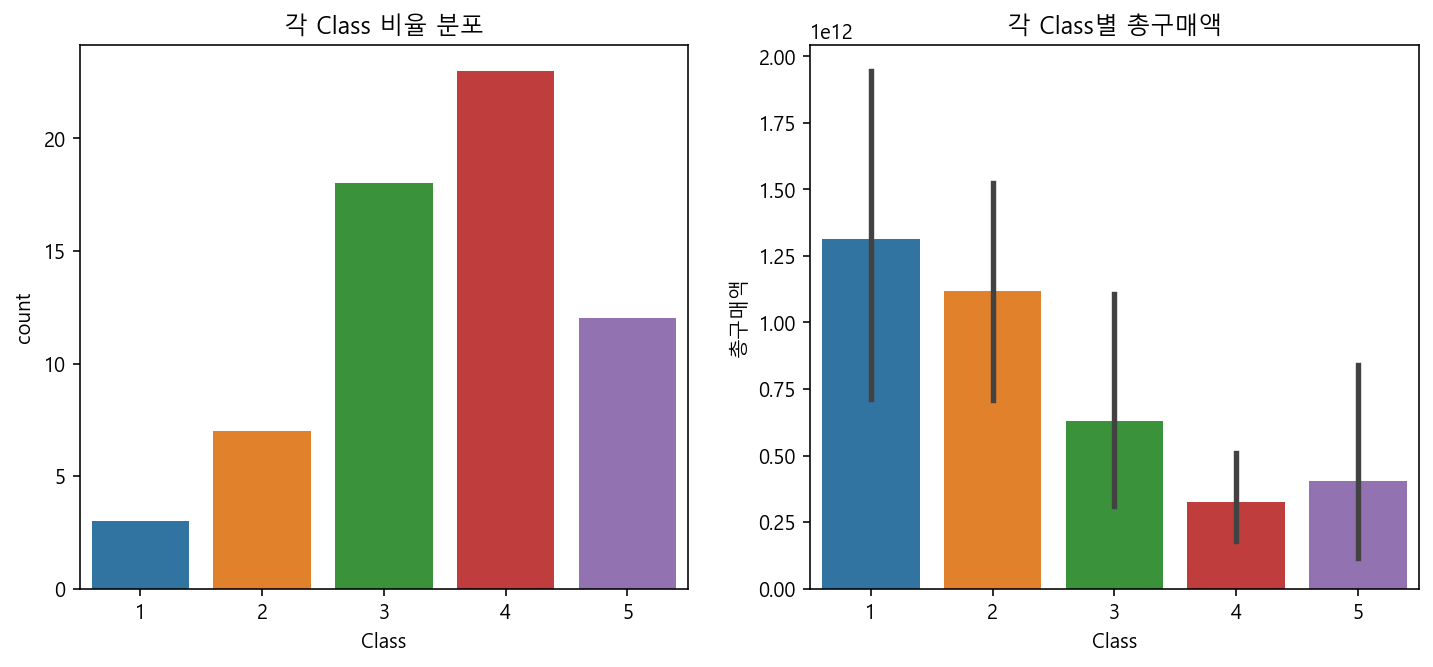

In [127]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.countplot(final_rfm.Class)
plt.title('각 Class 비율 분포')
plt.subplot(122)
sns.barplot(data=final_rfm, y='총구매액', x='Class')
plt.title('각 Class별 총구매액')
plt.show()

## Class별 서비스산업

In [140]:
class1_df = final_rfm[final_rfm['Class']==1]
class2_df = final_rfm[final_rfm['Class']==2]
class3_df = final_rfm[final_rfm['Class']==3]
class4_df = final_rfm[final_rfm['Class']==4]
class5_df = final_rfm[final_rfm['Class']==5]

## Class 1번

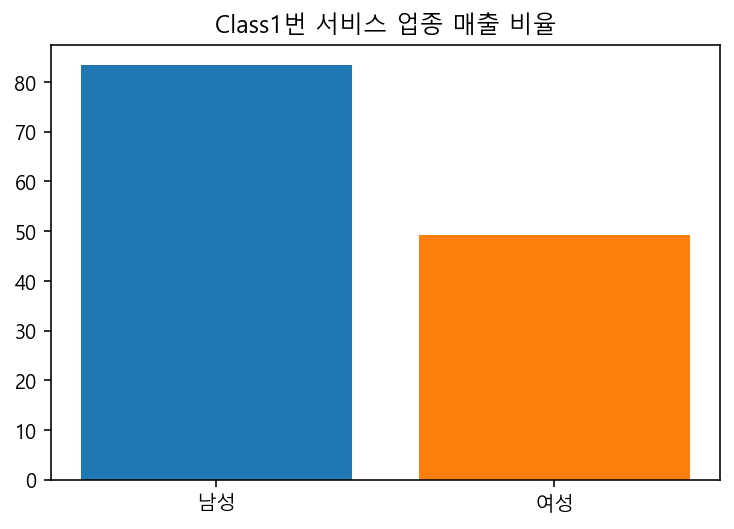

In [157]:
plt.title('Class1번 서비스 업종 매출 비율')
plt.bar(x='남성', height=class1_df['남성_매출_비율'])
plt.bar(x='여성', height=class1_df['여성_매출_비율'])
plt.show()

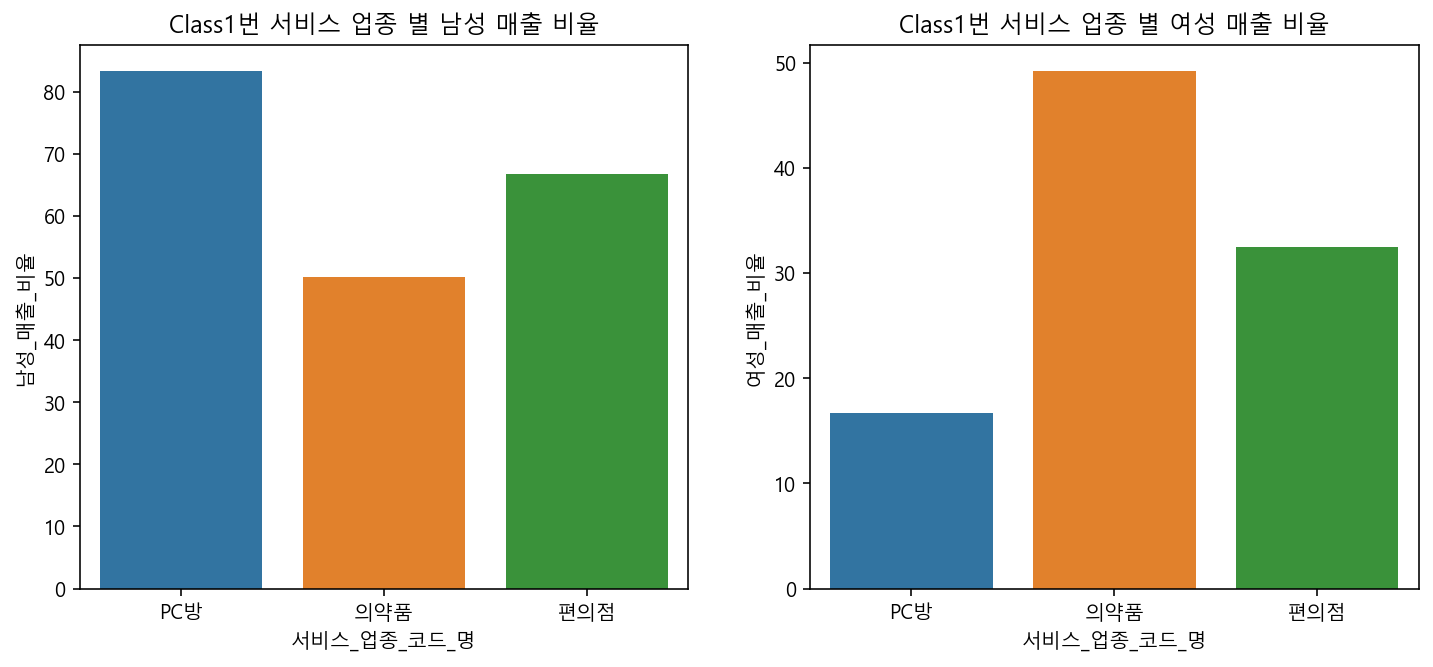

In [160]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title('Class1번 서비스 업종 별 남성 매출 비율')
sns.barplot(data=class1_df, x=class1_df.index, y='남성_매출_비율')

plt.subplot(122)
plt.title('Class1번 서비스 업종 별 여성 매출 비율')
sns.barplot(data=class1_df, x=class1_df.index, y='여성_매출_비율')
plt.show()

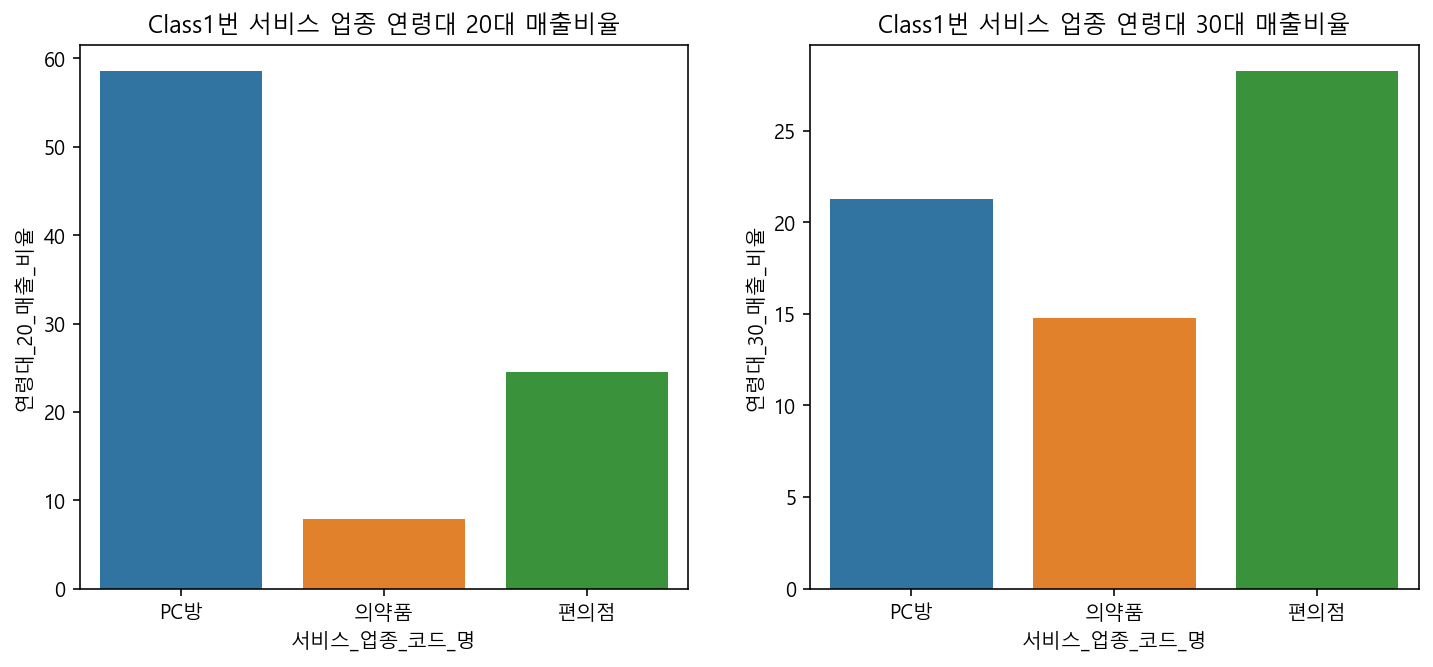

In [164]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title('Class1번 서비스 업종 연령대 20대 매출비율')
sns.barplot(data=class1_df, x=class1_df.index, y='연령대_20_매출_비율')

plt.subplot(122)
plt.title('Class1번 서비스 업종 연령대 30대 매출비율')
sns.barplot(data=class1_df, x=class1_df.index, y='연령대_30_매출_비율')
plt.show()

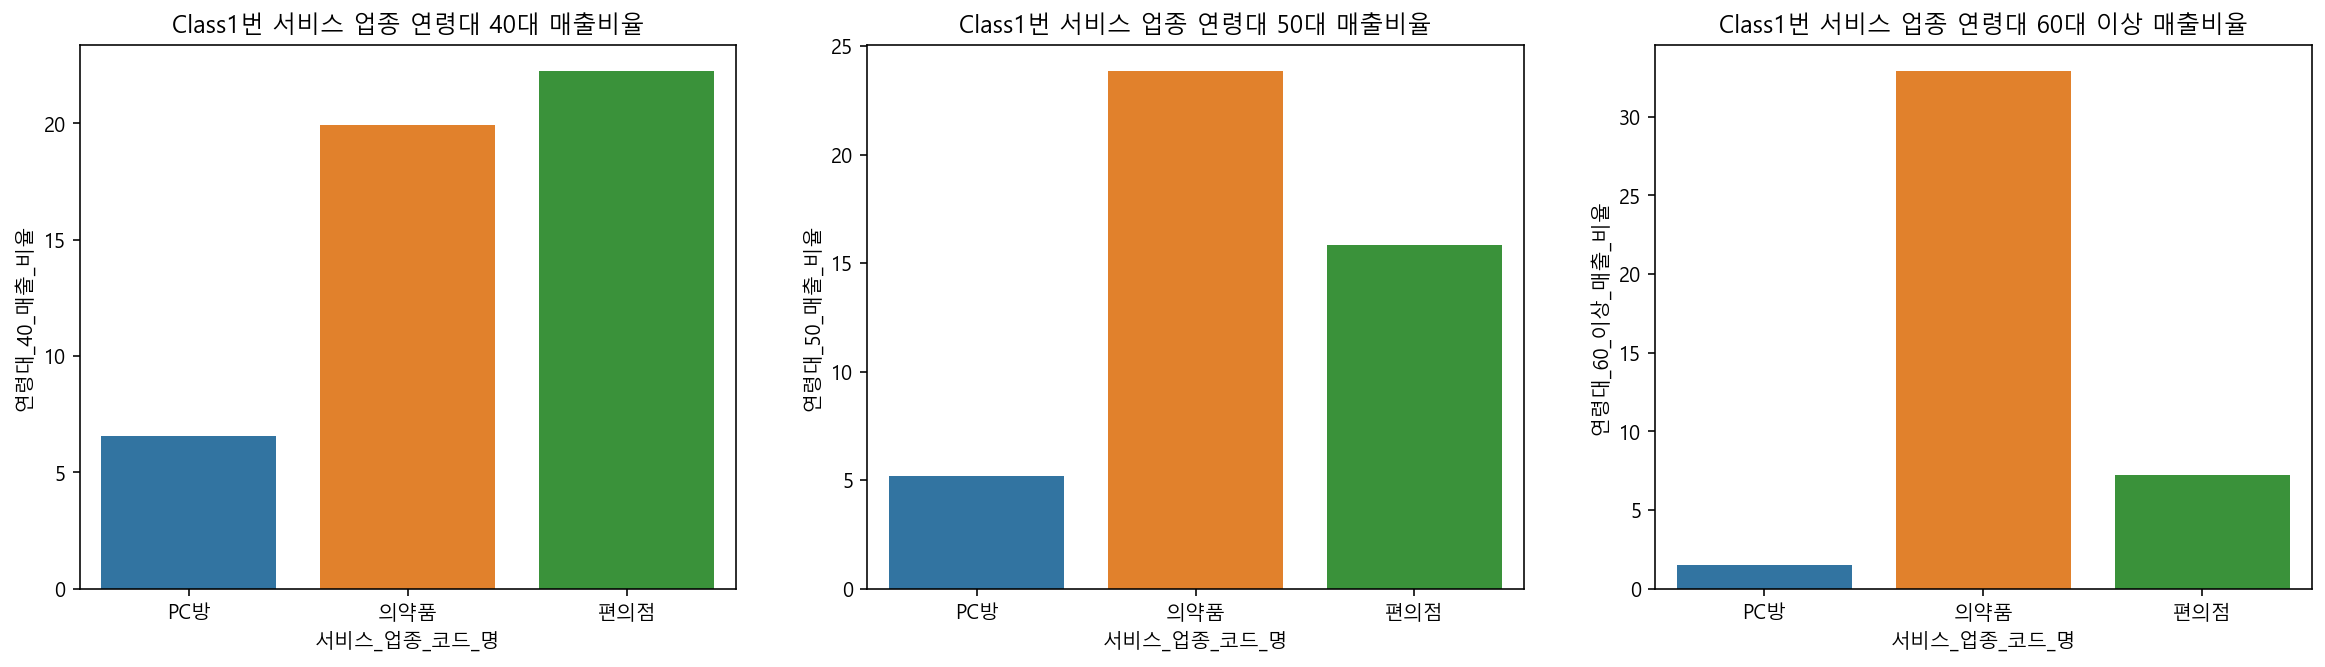

In [174]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.title('Class1번 서비스 업종 연령대 40대 매출비율')
sns.barplot(data=class1_df, x=class1_df.index, y='연령대_40_매출_비율')

plt.subplot(132)
plt.title('Class1번 서비스 업종 연령대 50대 매출비율')
sns.barplot(data=class1_df, x=class1_df.index, y='연령대_50_매출_비율')

plt.subplot(133)
plt.title('Class1번 서비스 업종 연령대 60대 이상 매출비율')
sns.barplot(data=class1_df, x=class1_df.index, y='연령대_60_이상_매출_비율')
plt.show()

## Class2

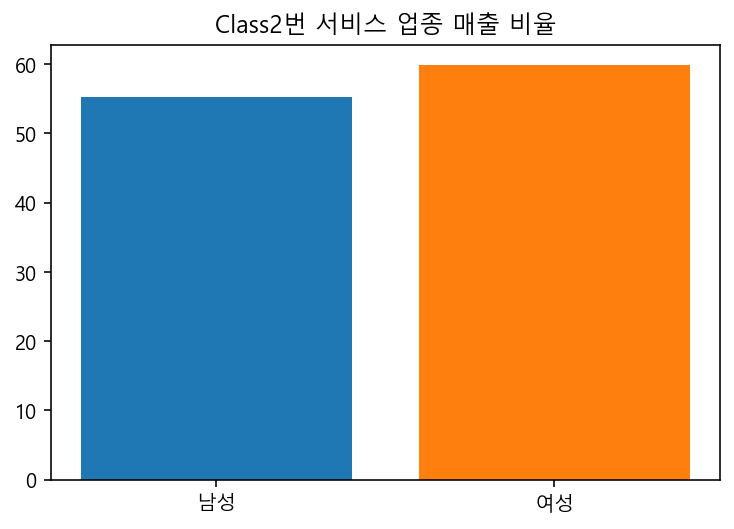

In [168]:
plt.title('Class2번 서비스 업종 매출 비율')
plt.bar(x='남성', height=class2_df['남성_매출_비율'])
plt.bar(x='여성', height=class2_df['여성_매출_비율'])
plt.show()

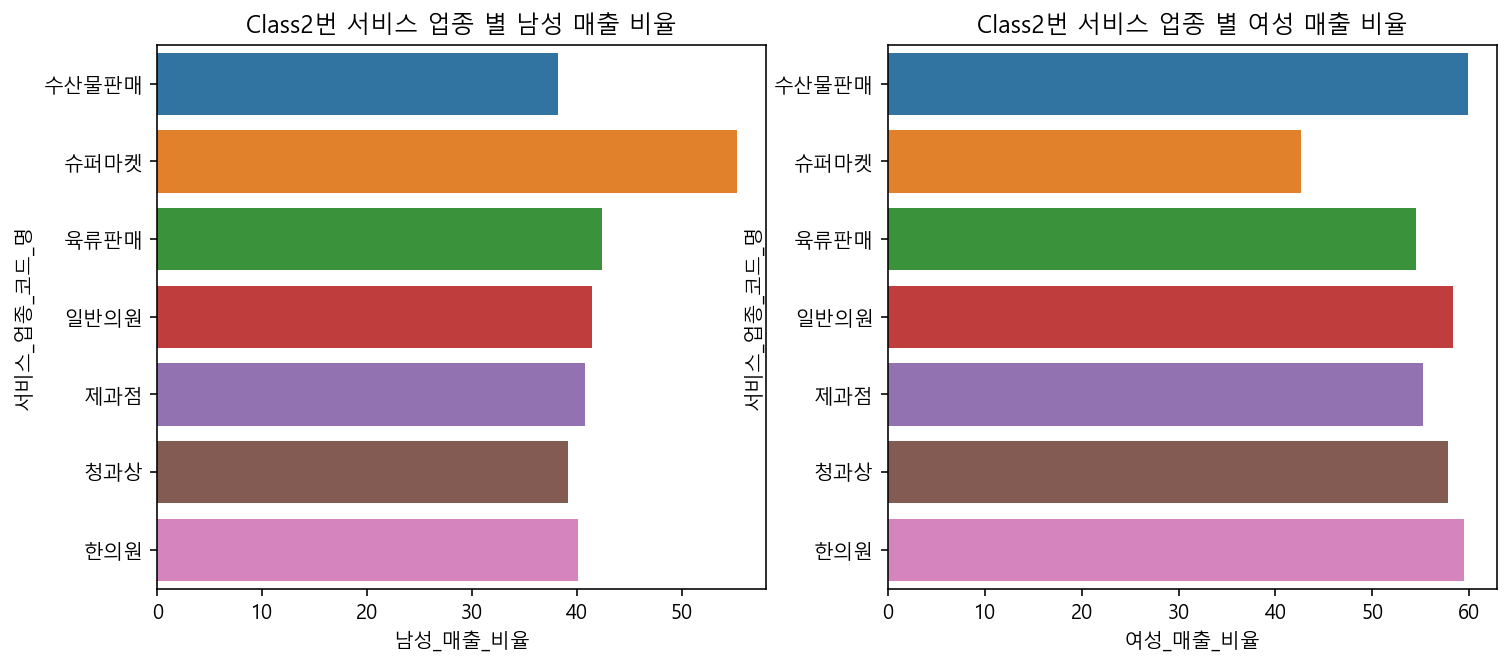

In [170]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title('Class2번 서비스 업종 별 남성 매출 비율')
sns.barplot(data=class2_df, y=class2_df.index, x='남성_매출_비율')

plt.subplot(122)
plt.title('Class2번 서비스 업종 별 여성 매출 비율')
sns.barplot(data=class2_df, y=class2_df.index, x='여성_매출_비율')
plt.show()

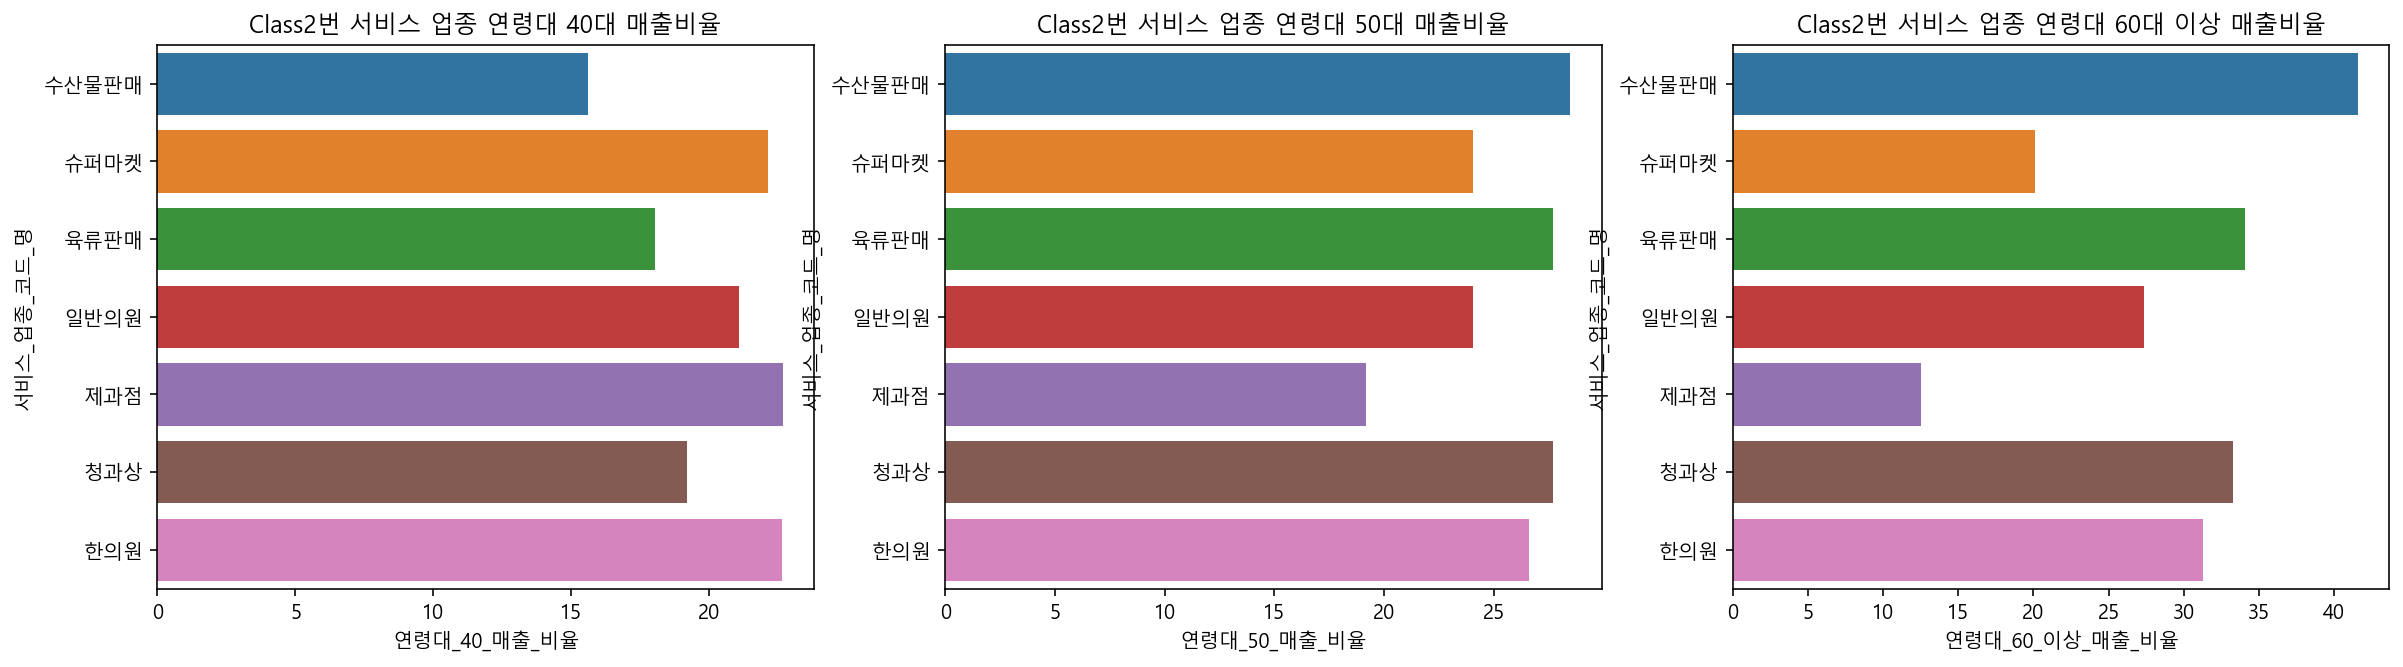

In [173]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('Class2번 서비스 업종 연령대 40대 매출비율')
sns.barplot(data=class2_df, y=class2_df.index, x='연령대_40_매출_비율')

plt.subplot(132)
plt.title('Class2번 서비스 업종 연령대 50대 매출비율')
sns.barplot(data=class2_df, y=class2_df.index, x='연령대_50_매출_비율')

plt.subplot(133)
plt.title('Class2번 서비스 업종 연령대 60대 이상 매출비율')
sns.barplot(data=class2_df, y=class2_df.index, x='연령대_60_이상_매출_비율')
plt.show()

# Class3

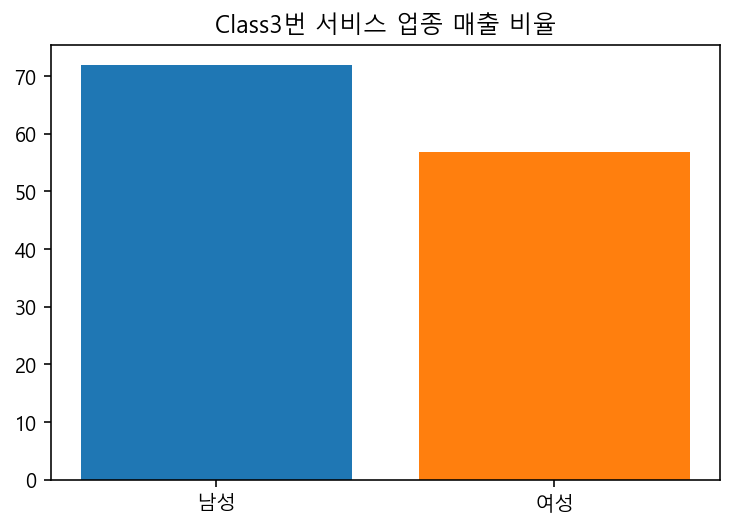

In [175]:
plt.title('Class3번 서비스 업종 매출 비율')
plt.bar(x='남성', height=class3_df['남성_매출_비율'])
plt.bar(x='여성', height=class3_df['여성_매출_비율'])
plt.show()

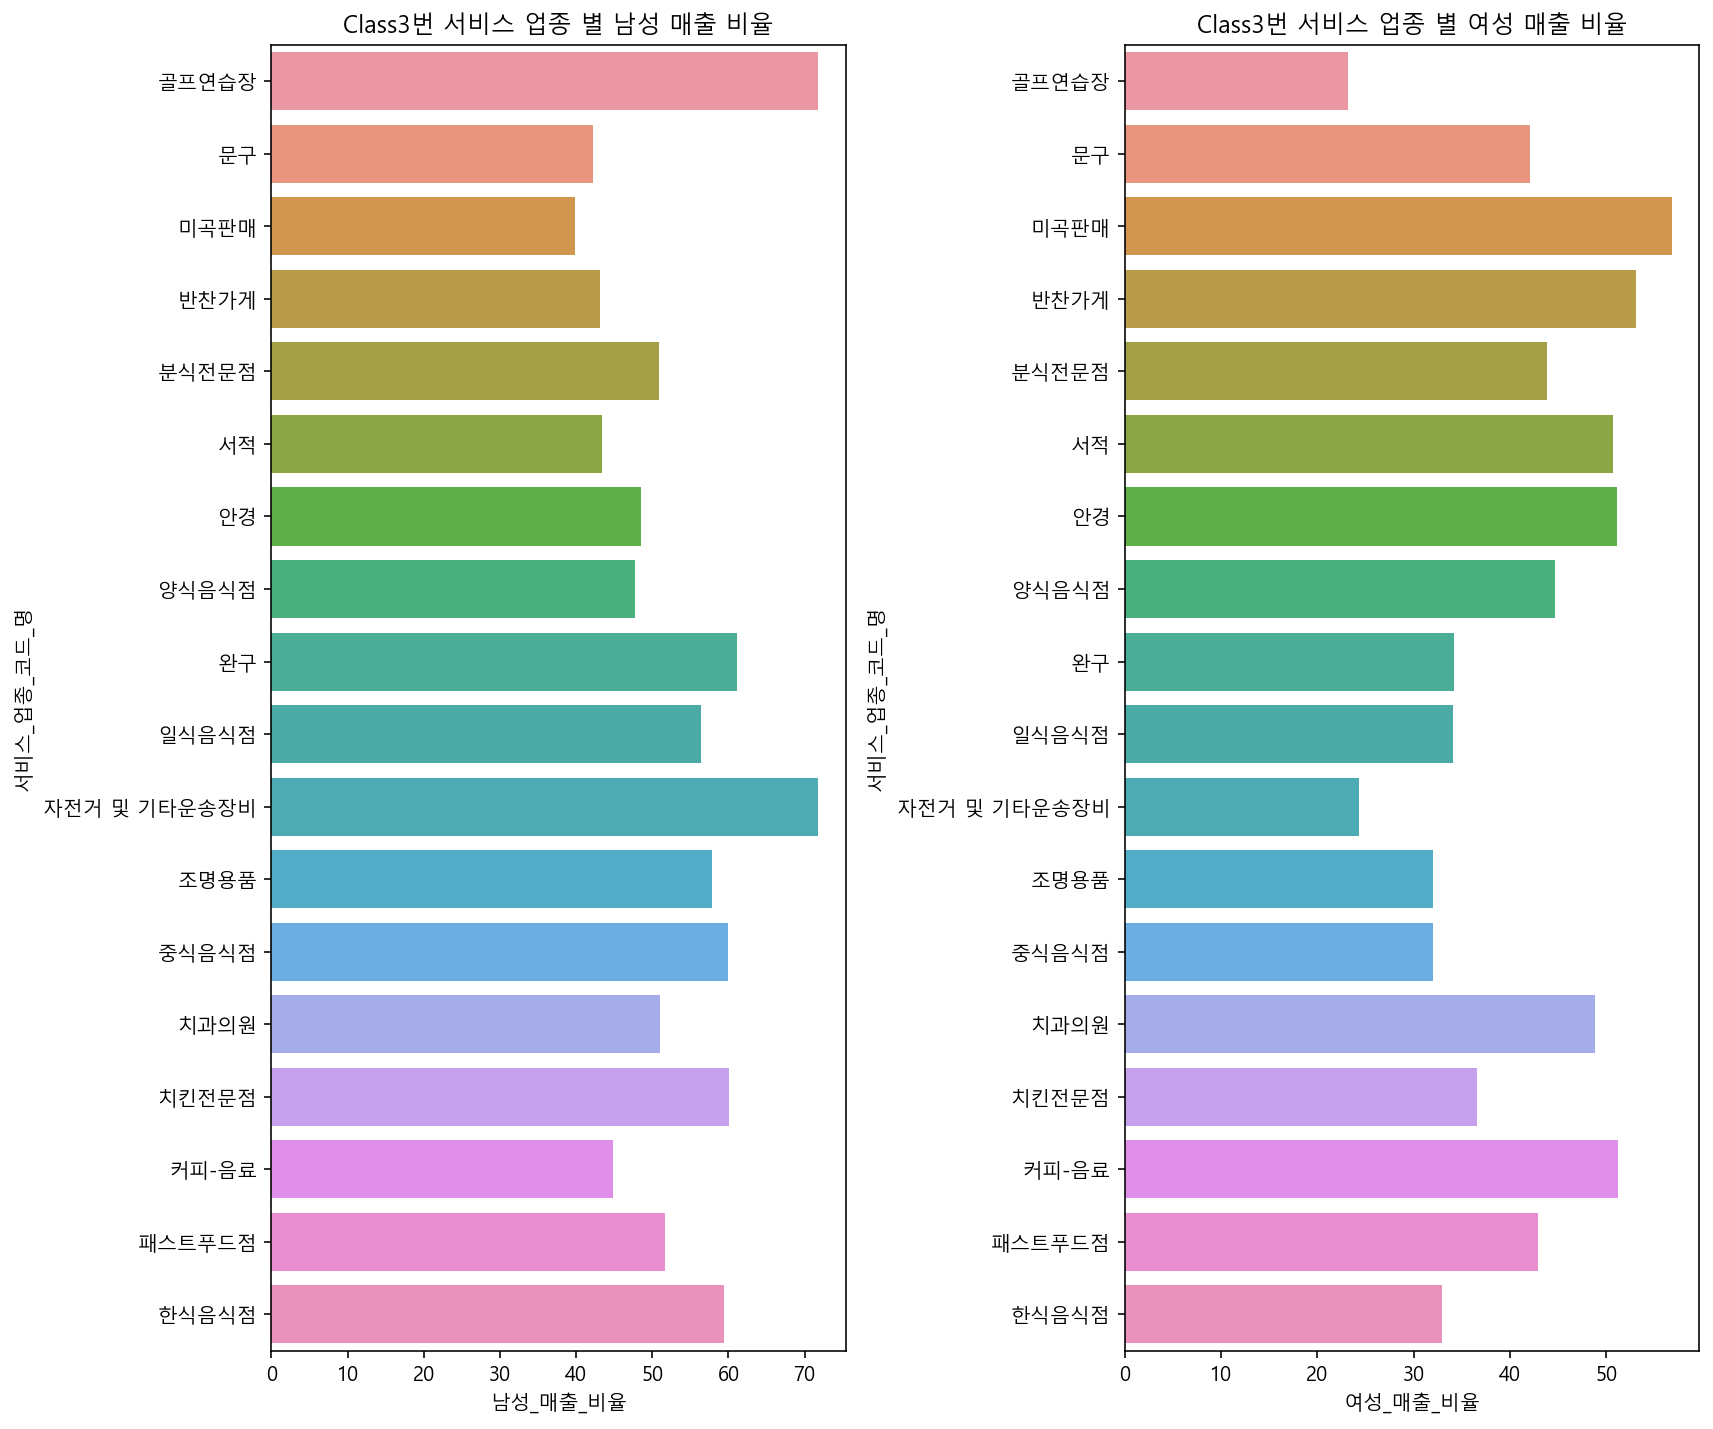

In [182]:
plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.title('Class3번 서비스 업종 별 남성 매출 비율')
sns.barplot(data=class3_df, y=class3_df.index, x='남성_매출_비율')

plt.subplot(122)
plt.title('Class3번 서비스 업종 별 여성 매출 비율')
sns.barplot(data=class3_df, y=class3_df.index, x='여성_매출_비율')
plt.tight_layout()
plt.show()

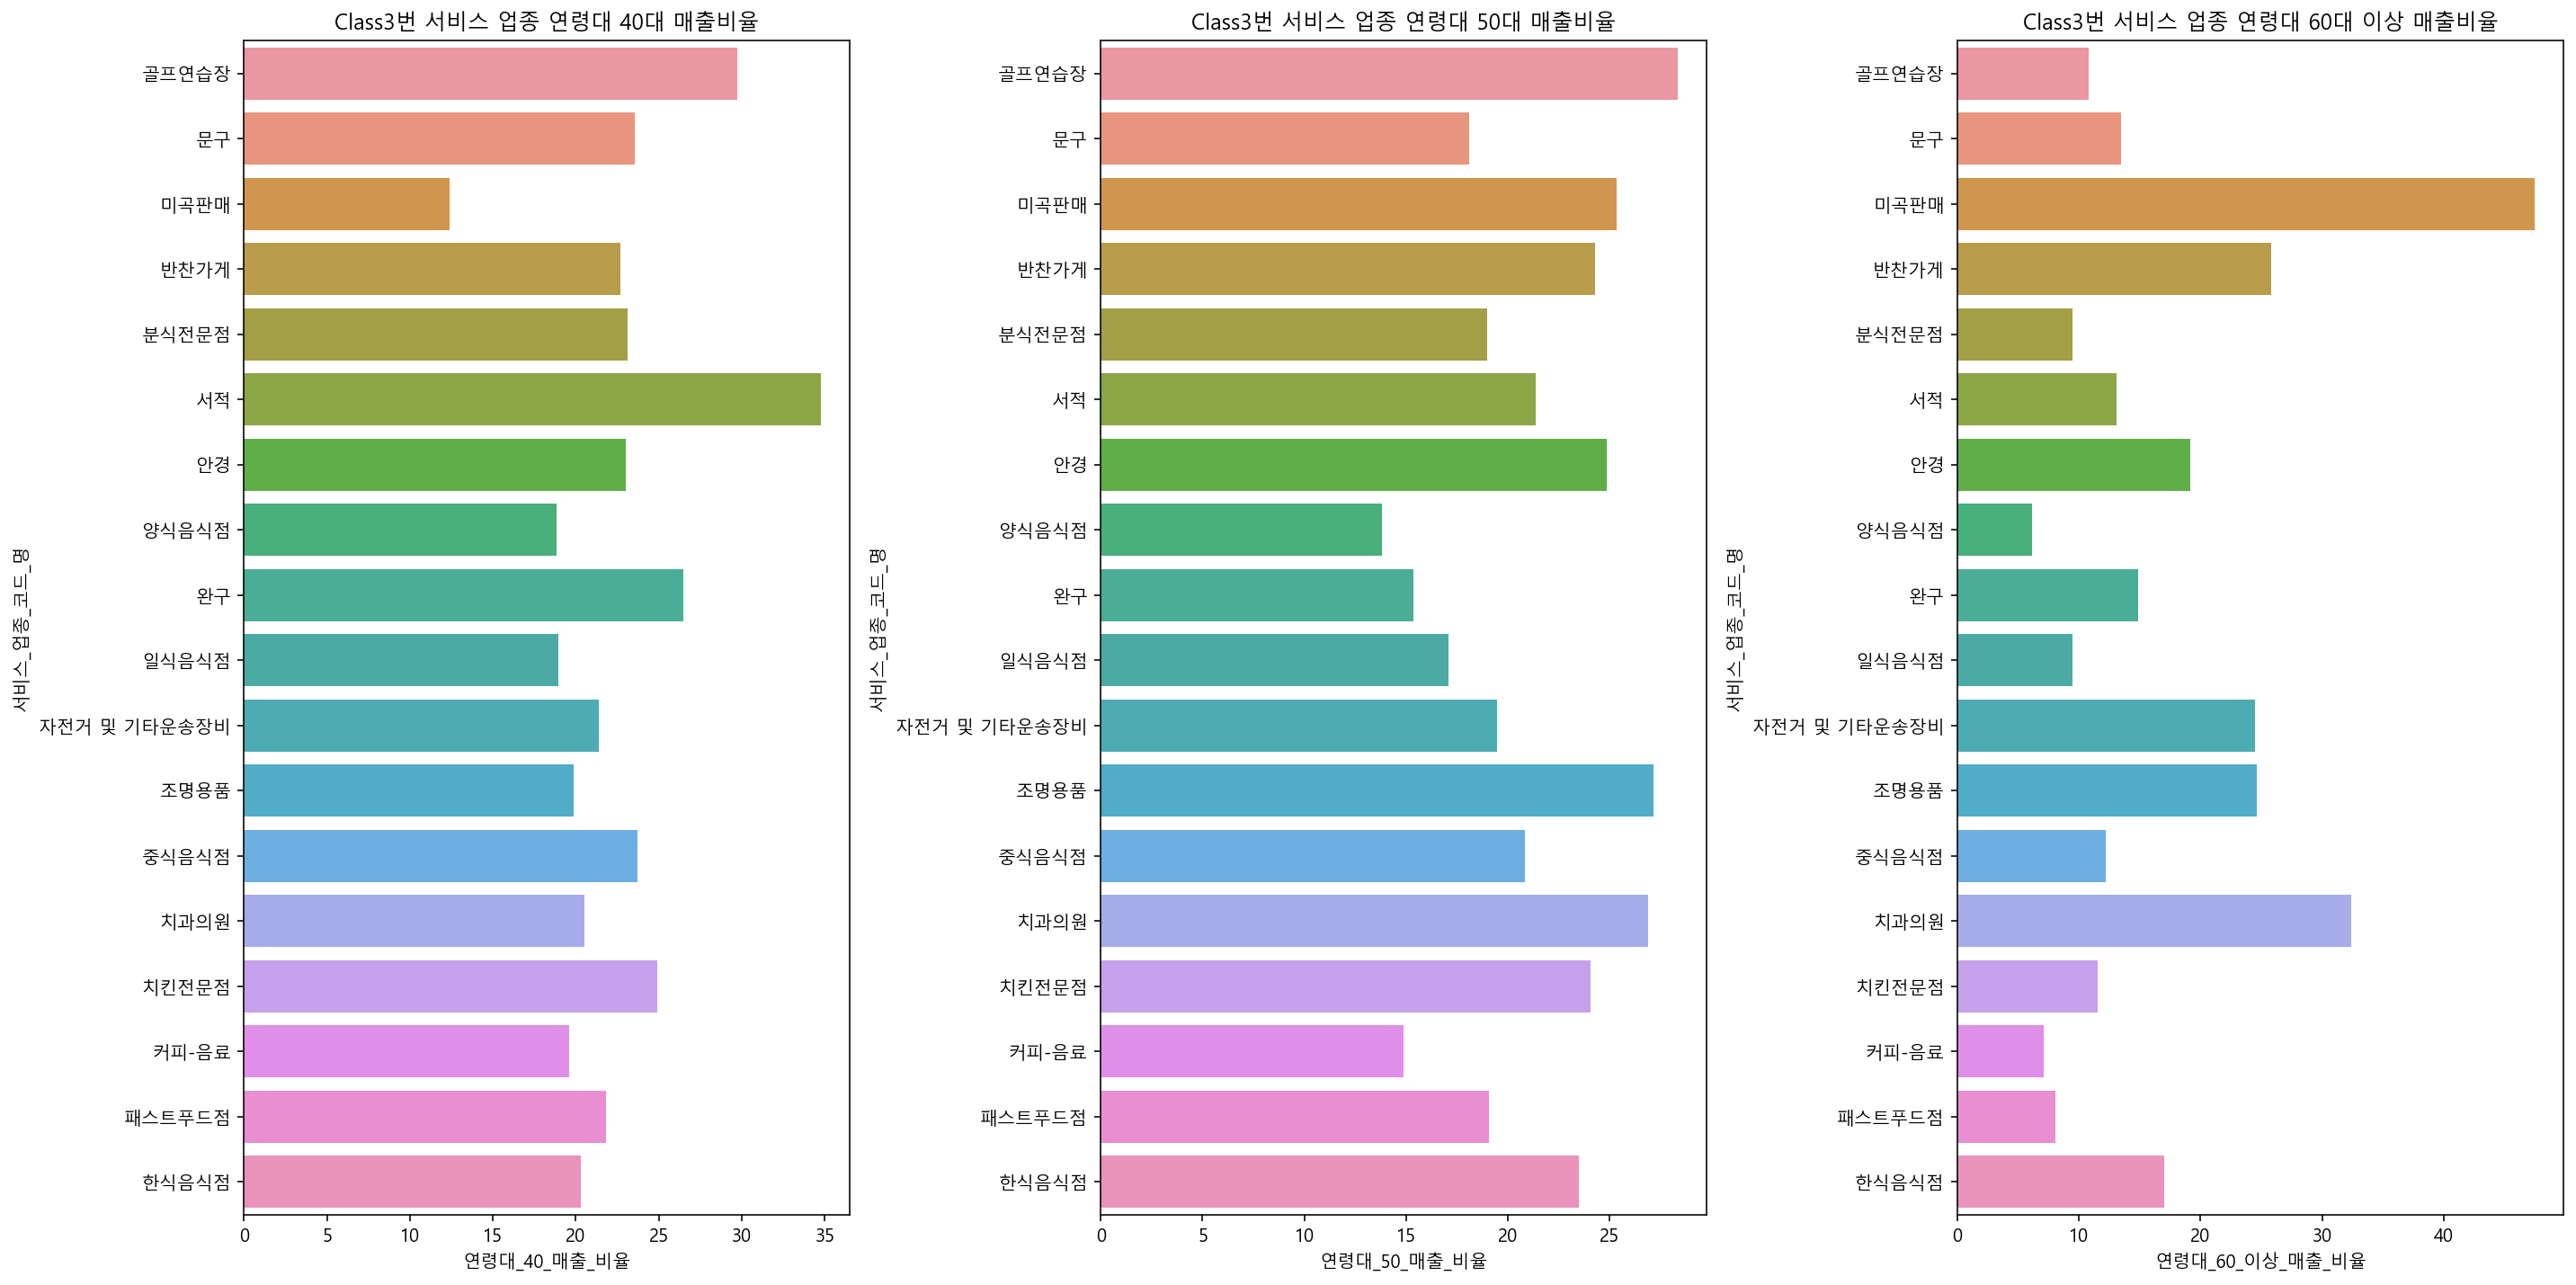

In [183]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Class3번 서비스 업종 연령대 40대 매출비율')
sns.barplot(data=class3_df, y=class3_df.index, x='연령대_40_매출_비율')

plt.subplot(132)
plt.title('Class3번 서비스 업종 연령대 50대 매출비율')
sns.barplot(data=class3_df, y=class3_df.index, x='연령대_50_매출_비율')

plt.subplot(133)
plt.title('Class3번 서비스 업종 연령대 60대 이상 매출비율')
sns.barplot(data=class3_df, y=class3_df.index, x='연령대_60_이상_매출_비율')

plt.tight_layout()
plt.show()

# Class4

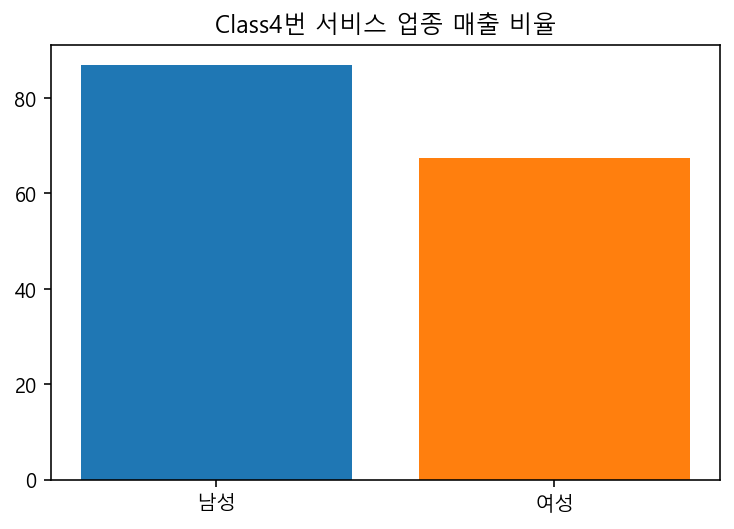

In [184]:
plt.title('Class4번 서비스 업종 매출 비율')
plt.bar(x='남성', height=class4_df['남성_매출_비율'])
plt.bar(x='여성', height=class4_df['여성_매출_비율'])
plt.show()

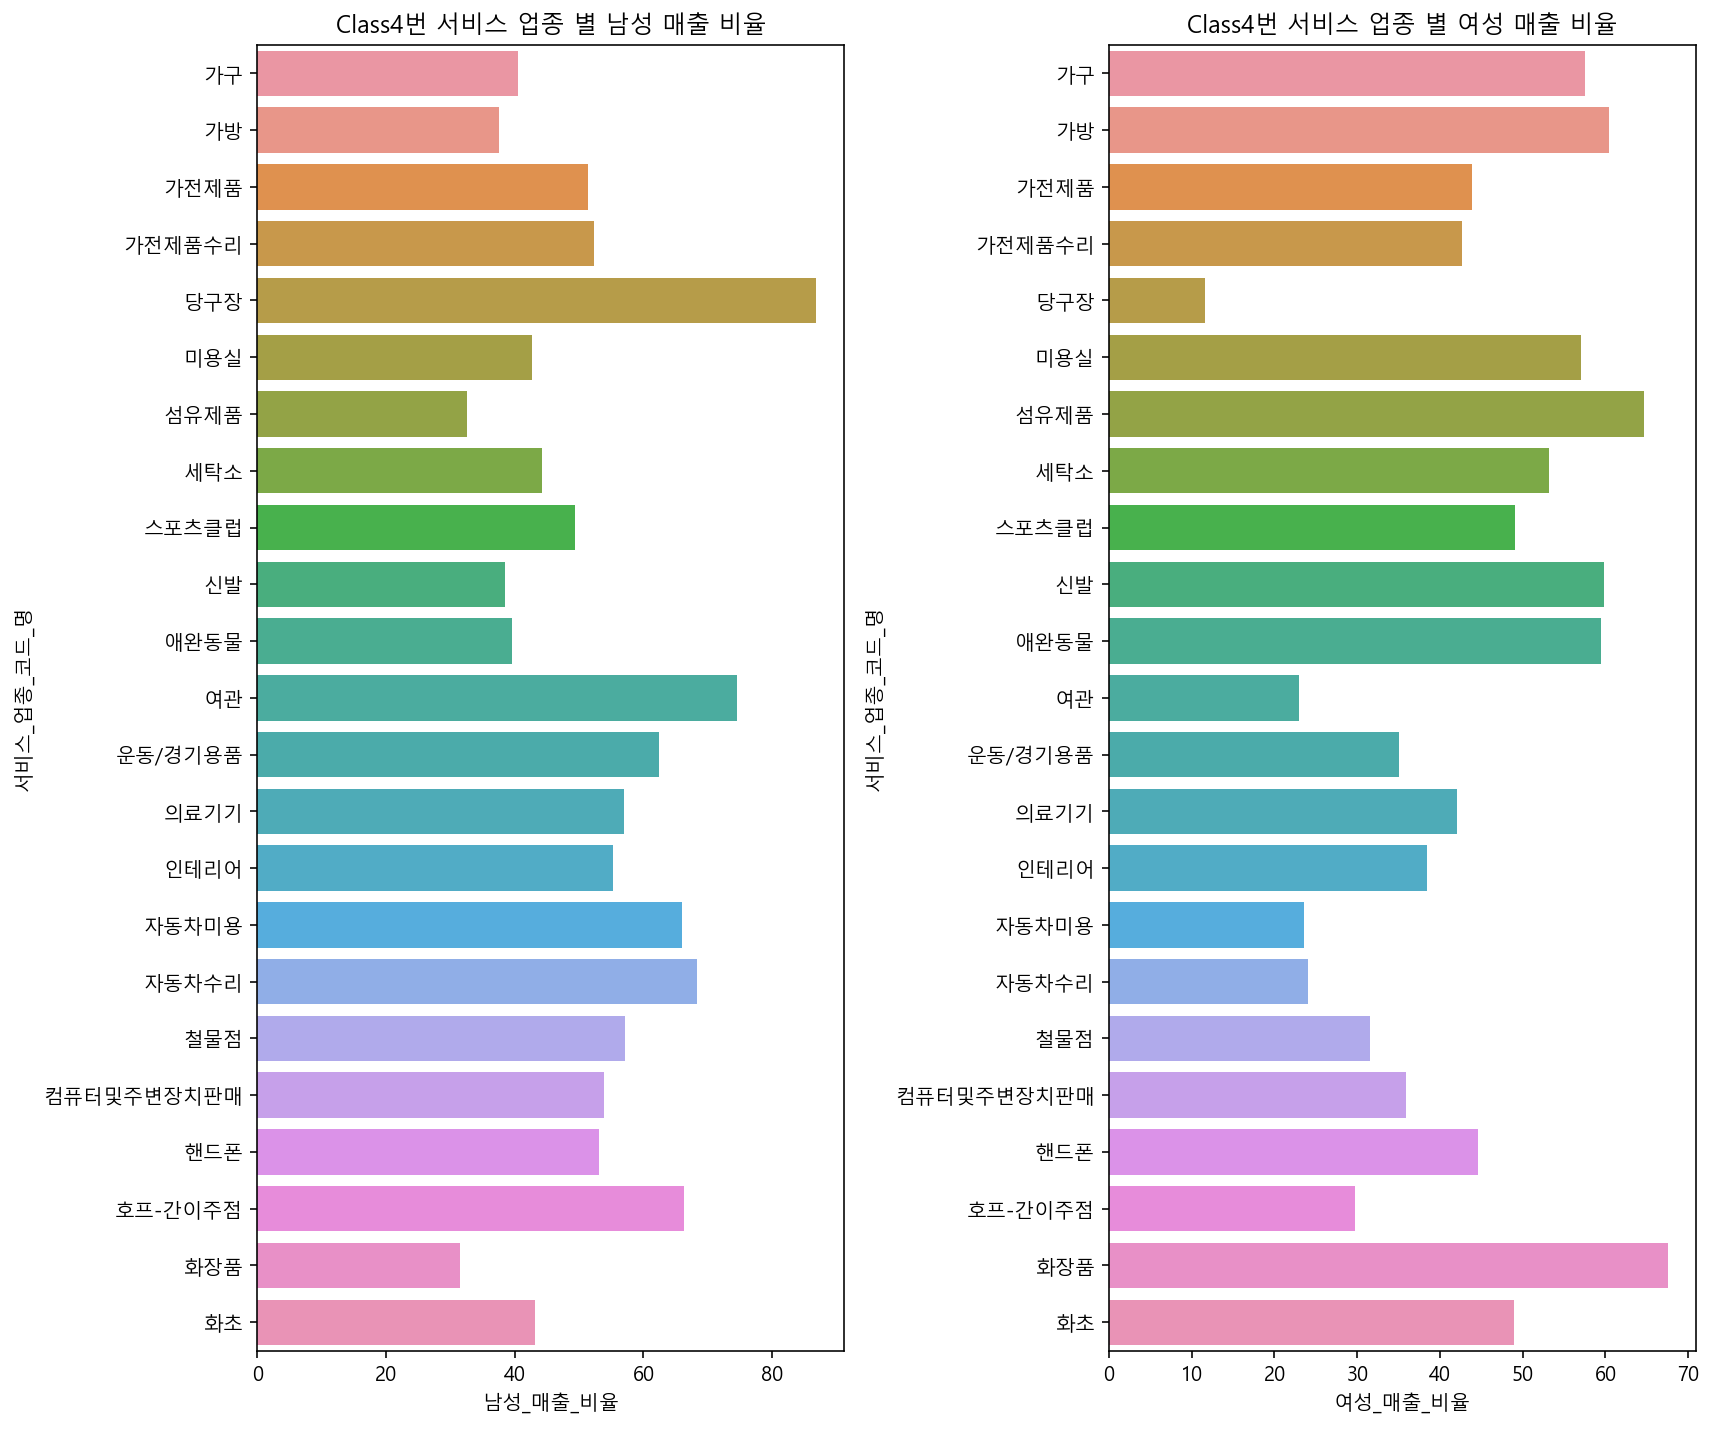

In [185]:
plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.title('Class4번 서비스 업종 별 남성 매출 비율')
sns.barplot(data=class4_df, y=class4_df.index, x='남성_매출_비율')

plt.subplot(122)
plt.title('Class4번 서비스 업종 별 여성 매출 비율')
sns.barplot(data=class4_df, y=class4_df.index, x='여성_매출_비율')
plt.tight_layout()
plt.show()

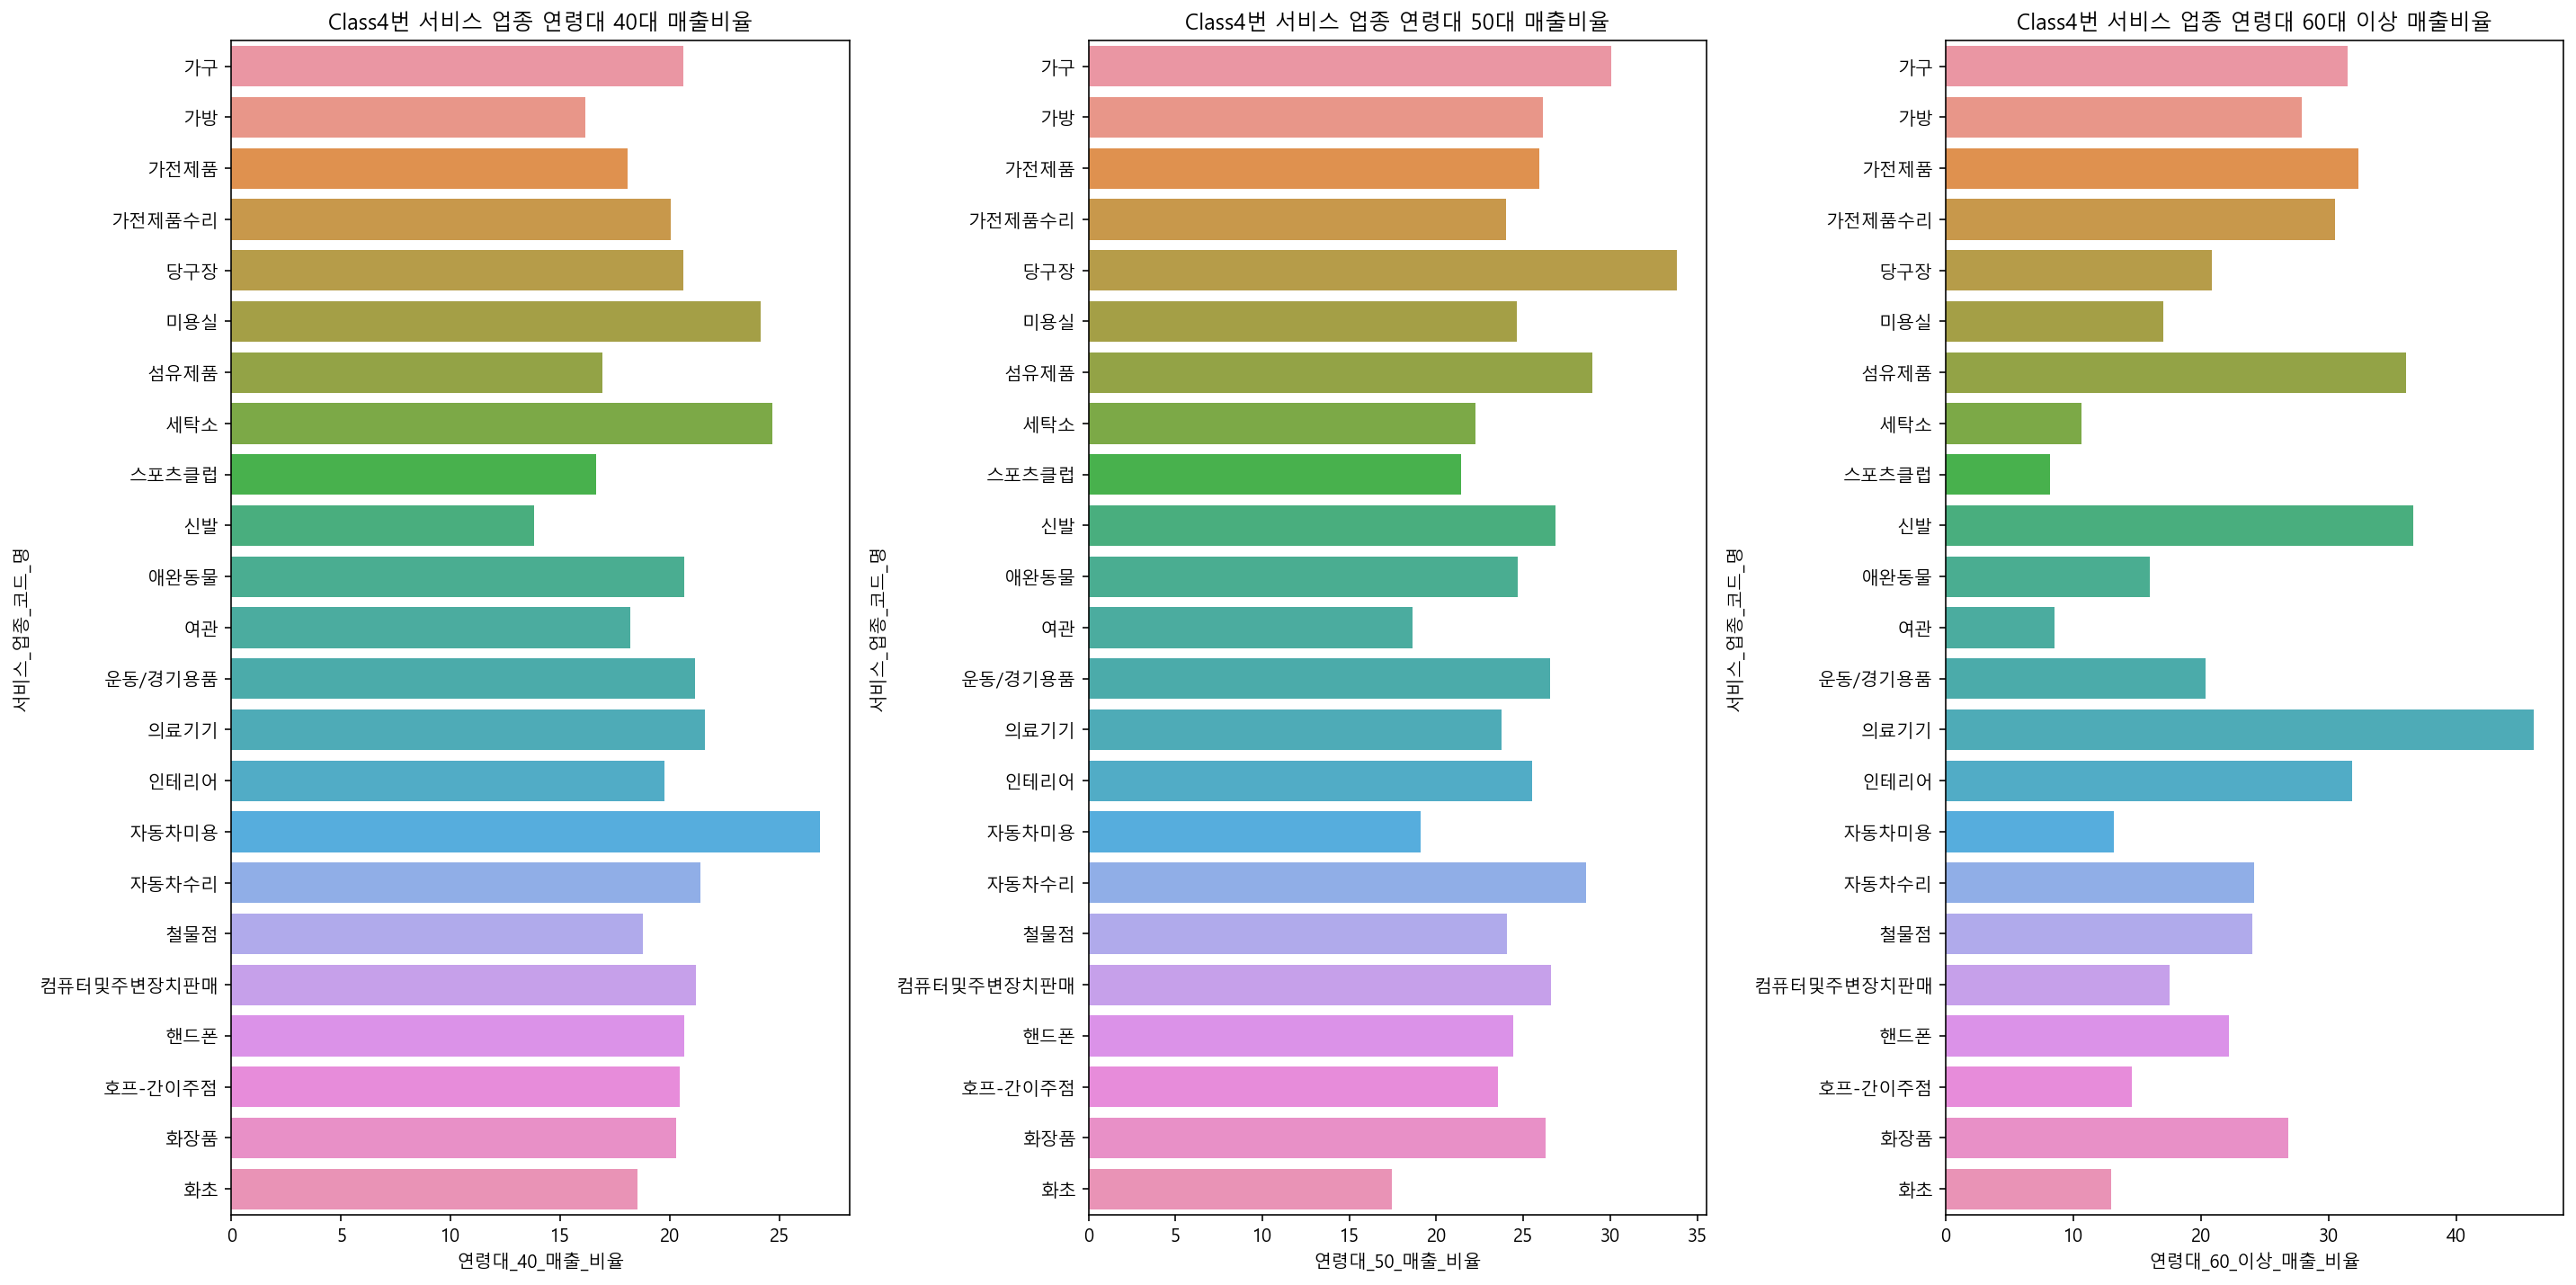

In [186]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Class4번 서비스 업종 연령대 40대 매출비율')
sns.barplot(data=class4_df, y=class4_df.index, x='연령대_40_매출_비율')

plt.subplot(132)
plt.title('Class4번 서비스 업종 연령대 50대 매출비율')
sns.barplot(data=class4_df, y=class4_df.index, x='연령대_50_매출_비율')

plt.subplot(133)
plt.title('Class4번 서비스 업종 연령대 60대 이상 매출비율')
sns.barplot(data=class4_df, y=class4_df.index, x='연령대_60_이상_매출_비율')

plt.tight_layout()
plt.show()

# Class5

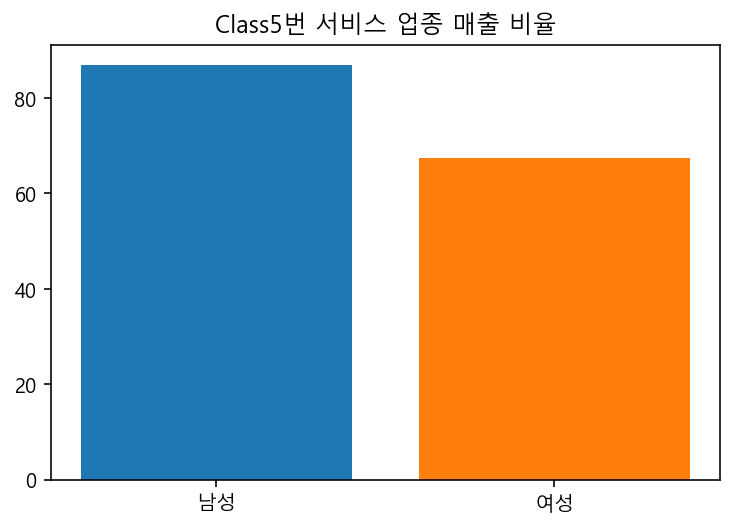

In [187]:
plt.title('Class5번 서비스 업종 매출 비율')
plt.bar(x='남성', height=class4_df['남성_매출_비율'])
plt.bar(x='여성', height=class4_df['여성_매출_비율'])
plt.show()

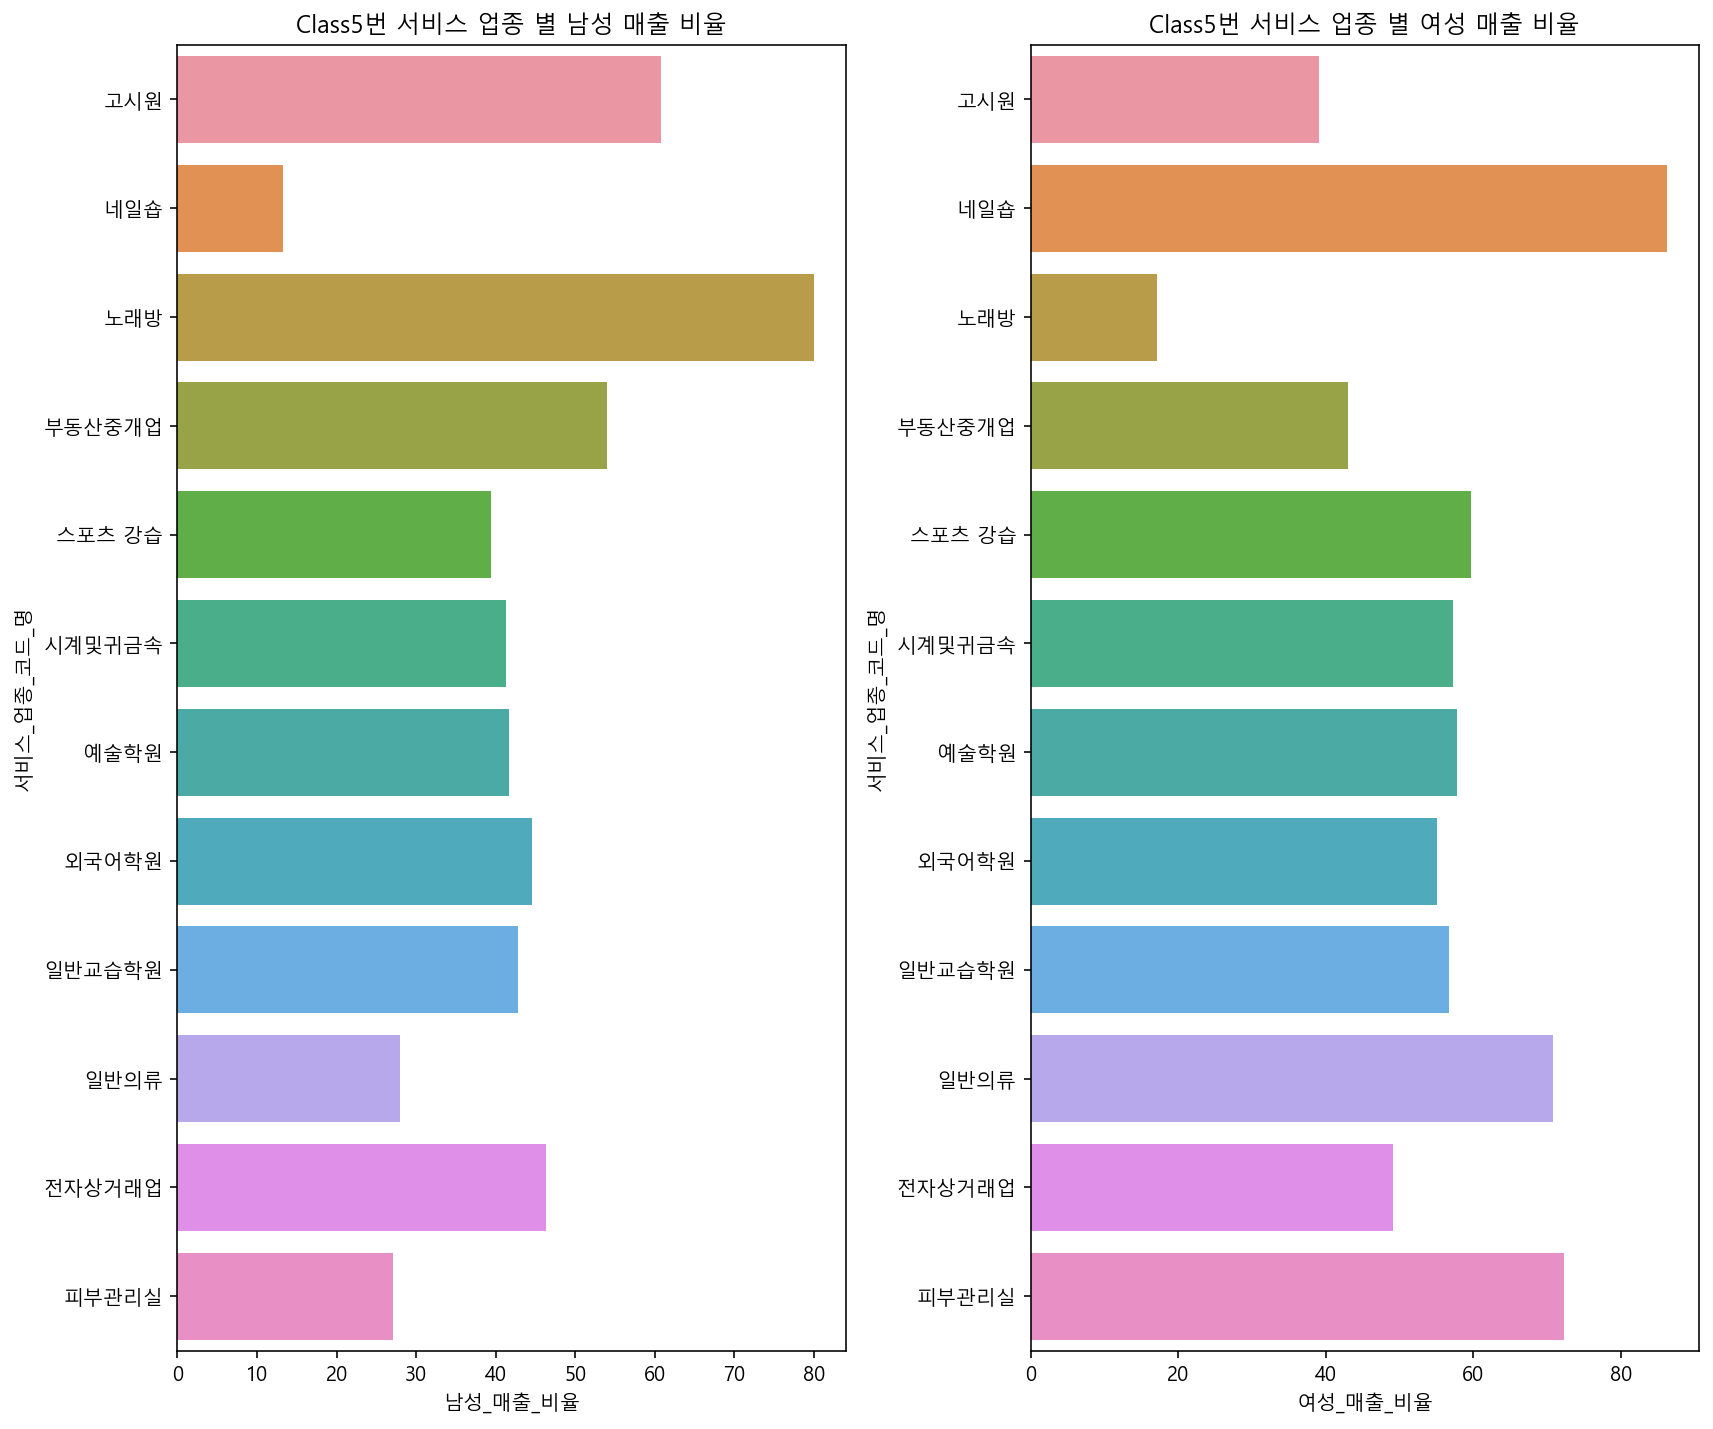

In [188]:
plt.figure(figsize=(12, 10))

plt.subplot(121)
plt.title('Class5번 서비스 업종 별 남성 매출 비율')
sns.barplot(data=class5_df, y=class5_df.index, x='남성_매출_비율')

plt.subplot(122)
plt.title('Class5번 서비스 업종 별 여성 매출 비율')
sns.barplot(data=class5_df, y=class5_df.index, x='여성_매출_비율')
plt.tight_layout()
plt.show()

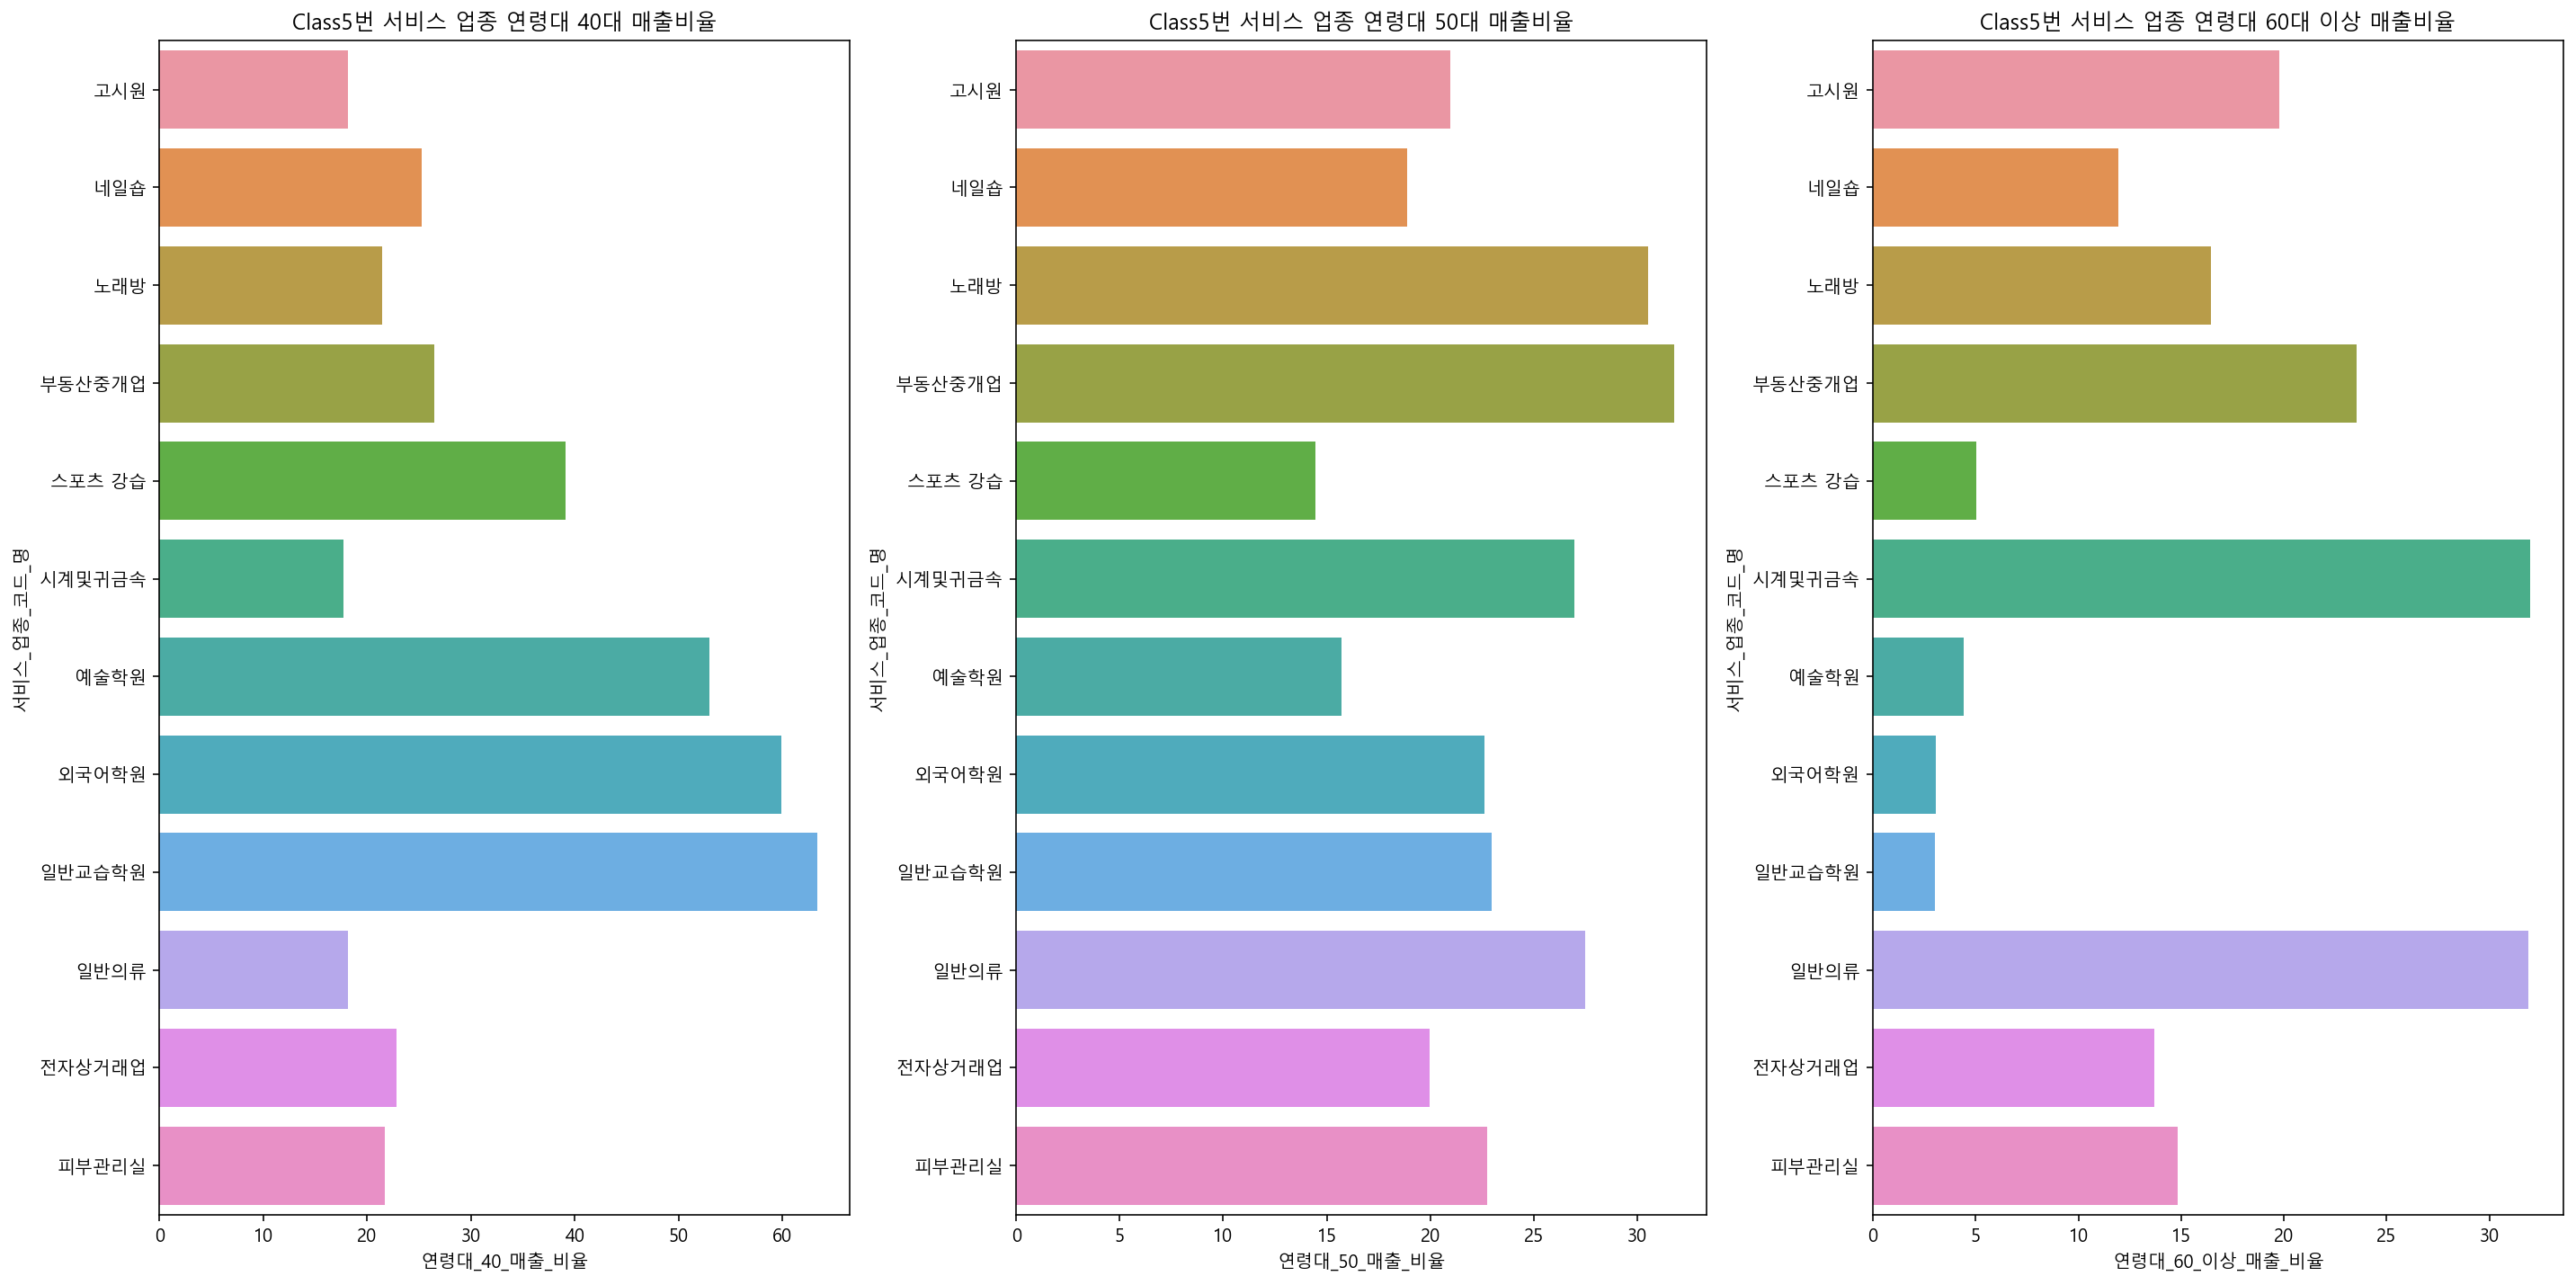

In [189]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Class5번 서비스 업종 연령대 40대 매출비율')
sns.barplot(data=class5_df, y=class5_df.index, x='연령대_40_매출_비율')

plt.subplot(132)
plt.title('Class5번 서비스 업종 연령대 50대 매출비율')
sns.barplot(data=class5_df, y=class5_df.index, x='연령대_50_매출_비율')

plt.subplot(133)
plt.title('Class5번 서비스 업종 연령대 60대 이상 매출비율')
sns.barplot(data=class5_df, y=class5_df.index, x='연령대_60_이상_매출_비율')

plt.tight_layout()
plt.show()